# Trace Veloce Spectra

Steps:
1. measure bias overscan + remove gaps
2. detect flux through thresholding to get initial trace for each order
   - flux for one row -> get threshold (median_filtr)
   - result: pixels belonging to orders, this is done on flats  
3. average in cross-dispersion (x) direction, and fit the polynomial 
4. work out summing range (manual)

In [1]:
import gc
import pickle
from astropy.io import fits
import os
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import median_filter

# from csaps import csaps

In [2]:
from simple_veloce_reduction import veloce_reduction_tools, veloce_config

In [3]:
# def add_alpha_channel(mask):
#     red_channel = 255*mask
#     green_channel = np.zeros_like(mask)
#     blue_channel = np.zeros_like(mask)
#     alpha_channel = 255*mask
#     return np.stack((red_channel, green_channel, blue_channel, alpha_channel), axis=-1)

def merge_masks_with_alpha(masks):
    # Assuming all masks have the same shape
    height, width = masks[0].shape
    
    # Initialize the red, green, blue, and alpha channels
    red_channel = np.zeros((height, width), dtype=np.uint8)
    green_channel = np.zeros((height, width), dtype=np.uint8)
    blue_channel = np.zeros((height, width), dtype=np.uint8)
    alpha_channel = np.zeros((height, width), dtype=np.uint8)
    
    # Combine all masks into the red and alpha channels
    for mask in masks:
        red_channel = 255*np.maximum(red_channel, mask)
        alpha_channel = 255*np.maximum(alpha_channel, mask)
    
    # Merge channels into a single image with an alpha channel
    merged_image = np.stack((red_channel, green_channel, blue_channel, alpha_channel), axis=-1)
    
    return merged_image

In [4]:
# from scipy.signal import fftconvolve

def determine_trace_shift(image, reference_image=None, row=None):
    if reference_image is None:
        # TODO: use master flat from CSV
        reference_image = image.copy()

    pix_shift = np.arange(-1*image.shape[1]+1, image.shape[1], 1)
    if row is None:
        ccf = np.zeros((image.shape[0], image.shape[1]*2-1))
        for row in range(image.shape[0]):
            ccf[row] = np.correlate(image[row,:], reference_image[row,:], mode='full')
    else:
        ccf = np.correlate(image[row,:], reference_image[row,:], mode='full')
    
    return pix_shift, ccf

In [3]:
%matplotlib inline

### Load Flat

In [5]:
# flat
amp_mode = 4
data_path = '/home/usqobserver2/VeloceData'
run = 'CSV_Run'

night = '230826'
# ccd = 'ccd_3'
# arm = 'red'
# filename = f'26aug30010.fits' #red
ccd = 'ccd_2'
arm = 'green'
filename = f'26aug20025.fits' #green
# ccd = 'ccd_1'
# arm = 'blue'
# filename = f'26aug10245.fits' #blue
# veloce_paths = veloce_config.VelocePaths(run)
# veloce_paths.__post_init__()

# spectrum_filename =  os.path.join(veloce_paths.raw_dir, night, ccd, filename)
spectrum_filename =  os.path.join(data_path, run, night, ccd, filename)

In [7]:
amp_mode_2 = 2
data_path = '/home/usqobserver2/VeloceData'
run_2 = 'Delta_Call_2025_accretion'
night_2 = '250404'
# ccd = 'ccd_3'
# arm = 'red'
# filename = f'04apr30015.fits' #red
ccd = 'ccd_2'
arm = 'green'
filename_2 = f'04apr20025.fits' #green
# ccd = 'ccd_1'
# arm = 'blue'
# filename_2 = f'04apr10220.fits' #blue

In [8]:
spectrum_filename =  os.path.join(data_path, run, night, ccd, filename)
spectrum_filename_2 =  os.path.join(data_path, run_2, night_2, ccd, filename_2)


In [4]:
# blue master flat
# amp_mode = 4
# ccd = 'ccd_1'
# arm = 'blue'
# spectrum_filename = '/home/usqobserver2/Joachim_veloce/Veloce_reduction/Master_data/master_flat_blue_long_230826.fits'

In [8]:
# ### flat from another run
# amp_mode = 4
# data_path = '/home/usqobserver2/VeloceData'
# run = '23xmasRun'
# night = '231228'
# ccd = 'ccd_2'
# filename = f'28dec20023.fits'
# spectrum_filename =  os.path.join(data_path, run, night, ccd, filename)

In [9]:
# ## 2 amp mode flat
# amp_mode = 2
# # data_path = '/home/usqobserver2/VeloceData'
# run = 'WASP189b'
# night = '240410'
# ccd = 'ccd_2'
# arm = 'green'
# filename = f'10apr20025.fits'
# # ccd = 'ccd_1'
# # arm = 'blue'
# # filename = f'10apr10045.fits'
# veloce_paths = veloce_path.VelocePaths(run)
# veloce_paths.__post_init__()

# spectrum_filename =  os.path.join(veloce_paths.raw_dir, night, ccd, filename)

In [28]:
plt.close('all')

### 1. Measure overscan bias and remove gaps

In [ ]:
image_subtracted_bias = veloce_reduction_tools.remove_overscan_bias(image_data, hdr=header, arm=arm, amplifier_mode=amp_mode, overscan_range=32)
image_subtracted_bias_2 = veloce_reduction_tools.remove_overscan_bias(image_data_2, hdr=header, arm=arm, amplifier_mode=amp_mode_2, overscan_range=32)

Gain for quadrant 1: 1.01
Gain for quadrant 2: 1.01
Gain for quadrant 3: 1.01
Gain for quadrant 4: 1.01
Gain for half 1: 1.01
Gain for half 2: 0.97364


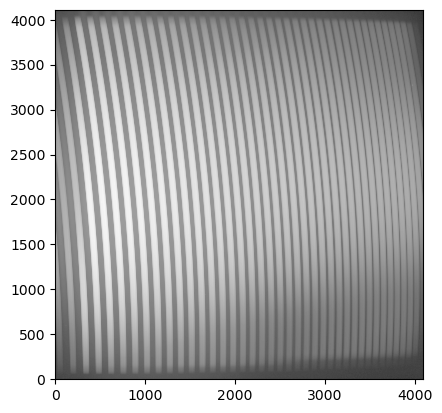

In [17]:
plt.figure()
plt.imshow(image_subtracted_bias, cmap='gray', norm="symlog", origin='lower')
plt.show()

In [60]:
filename = os.path.join('/home/usqobserver2/Joachim_veloce/veloce_reduction_dev/veloce_reduction/Trace', f'veloce_{arm}_4amp_no_sim_calib_trace.pkl')
traces = veloce_reduction_tools.Traces.load_traces(filename)

In [30]:
extracted_science_orders, extracted_order_imgs = veloce_reduction_tools.extract_orders_with_trace(
                            image_subtracted_bias, traces, remove_background=False)

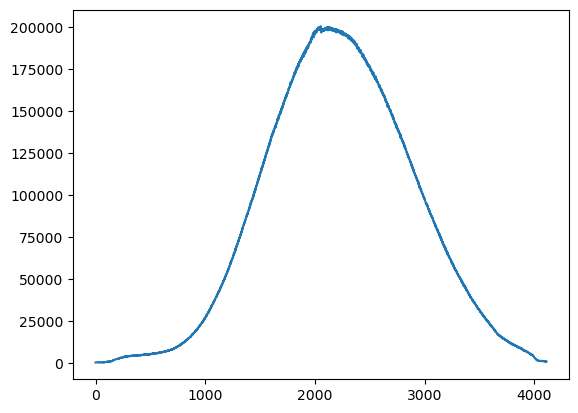

In [33]:
plt.plot(extracted_science_orders[17])

In [30]:
plt.close('all')

### Determine trace shift with ccf

In [ ]:
# from simple_veloce_reduction import veloce_extraction

In [ ]:
# image_subtracted_bias, hdr = veloce_extraction.remove_scattered_light(image_subtracted_bias, header, traces, False)

In [19]:
# pix_shift, ccf = determine_trace_shift(image_subtracted_bias_2, reference_image=image_subtracted_bias, row=2000)
pix_shift, ccf = determine_trace_shift(image_subtracted_bias_2, reference_image=image_subtracted_bias)


In [11]:
# %matplotlib inline
%matplotlib widget

In [ ]:
# for i in range(ccf.shape[0]):
#     print(pix_shift[np.argmax(ccf[i])])
# pix_shift[np.argmax(ccf)]

-2

In [18]:
plt.plot(pix_shift, ccf)
# plt.plot(pix_shift, ccf[2000,:])
# plt.plot(pix_shift, ccf[:,2000])
plt.vlines(0, ccf.min(), ccf.max(), color='r', linestyle='--')
# plt.xlim(-100, 100)
plt.xlabel('Pixel Shift')
plt.ylabel('CCF')

Text(55.847222222222214, 0.5, 'CCF')

In [15]:
plt.close('all')

### 2a. Load prefitted traces for calib fibers

Load prefitted trace to refit or skip to determining orders from flux in flat images

In [11]:
order_nums, coeffs, traces = veloce_reduction_tools.load_prefitted_wavecalib_trace(arm=arm, calib_type='Th')

In [16]:
input_dir = os.path.join(data_path, run)
output_dir = os.path.join('/home/usqobserver2/Joachim_veloce/Veloce_reduction/Trace/')
veloce_paths = veloce_config.VelocePaths(input_dir, output_dir, run=run)
# veloce_paths.__post_init__()

 does not match run name: Delta_Call_2025_accretion
Creating output subdirectory with run name.


In [17]:
trace_path = veloce_paths.trace_dir
if not os.path.exists(trace_path):
    print(f"{trace_path} does not exist")
trace_filename = f'veloce_{arm}_4amp_sim_calib_trace.pkl'
traces = veloce_reduction_tools.Traces.load_traces(os.path.join(trace_path, trace_filename))
# trace_filename = f'veloce_{arm}_4amp_sim_calib_trace.pkl'
new_traces = veloce_reduction_tools.Traces.load_traces(os.path.join(trace_path, trace_filename))


In [13]:
# old format for saved traces
# trace_data = np.load('./Trace/veloce_green_4amp_no_sim_calib_trace.npz')
# traces, summing_ranges = trace_data['traces'], trace_data['summing_ranges']

In [25]:
%matplotlib widget

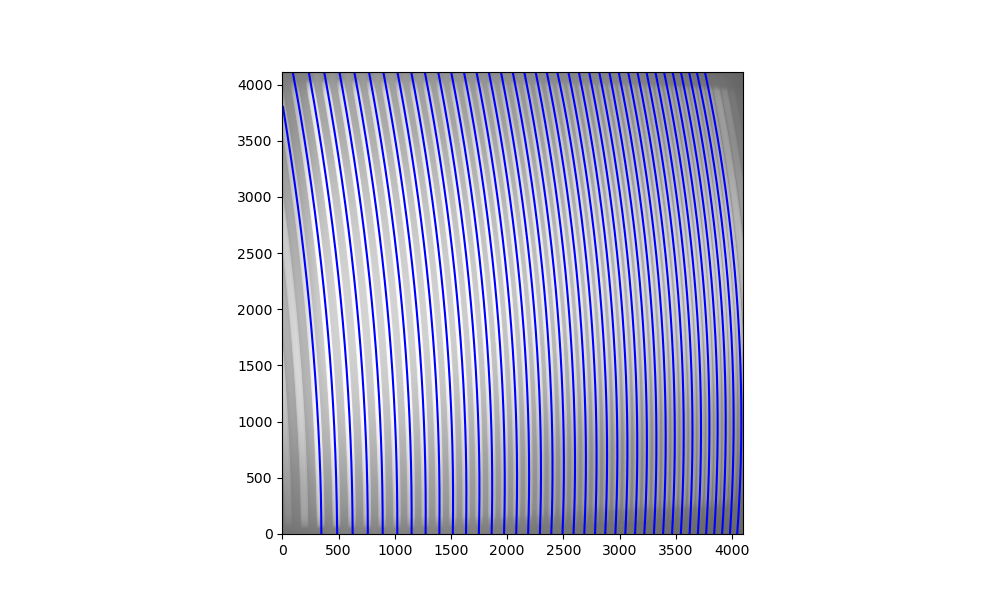

In [26]:
plt.figure(figsize=(10, 6))
plt.imshow(image_subtracted_bias, cmap='gray', norm="symlog", origin='lower')
for trace_y, trace_x in zip(traces.y, traces.x):
    plt.plot(trace_x, trace_y, 'b')
plt.show()

In [27]:
plt.close()

In [28]:
# Delete and collect garbage
del image_data
gc.collect()

9415

In [29]:
''' 
shape is consistent with info from manual 
but there is a row of 'bias' pixels at the top of the image (row 4111)
'''
image_subtracted_bias.shape

(4112, 4096)

### 2b. Detect flux through thresholding to get initial trace for each order

skip when refitting existing trace

In [81]:
# blured = median_filter(image_subtracted_bias, (5,15)) #blue
blured = median_filter(image_subtracted_bias, (1,21)) #green
# blured = median_filter(image_subtracted_bias, (10,10)) #red
# blured = median_filter(image_subtracted_bias, (5,5))

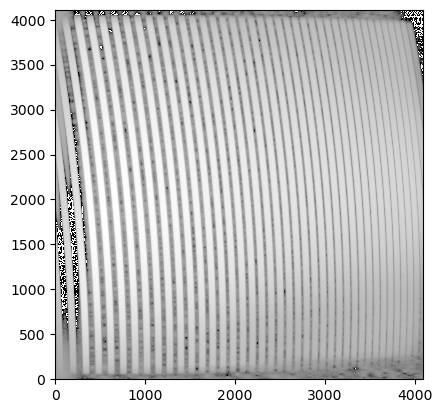

In [82]:
plt.figure()
plt.imshow(blured, cmap='gray', norm='log', origin='lower')
plt.show()
# blured = image_substracted_bias

In [83]:
plt.close()

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Cross-section at row 2000'}, xlabel='Pixel', ylabel='Counts'>)

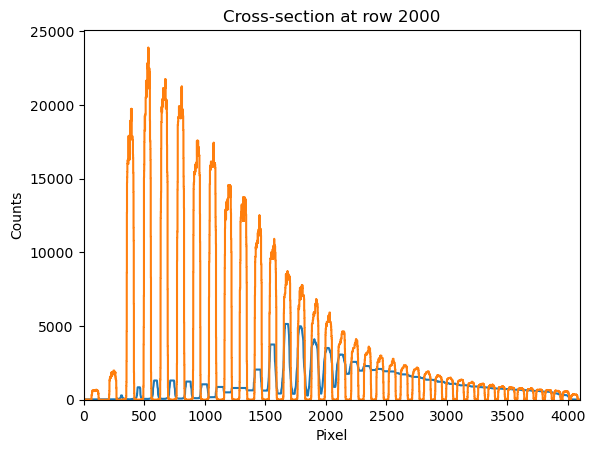

In [84]:
n = 2000
# veloce_reduction_tools.plot_cross_section(image_substracted_bias, n, axis='x')
veloce_reduction_tools.plot_cross_section(blured, n, axis='x')

In [85]:
plt.close('all')


Result: pixels belonging to orders, this is done on flats.

Threshold detected per row, as median filter with wide span

In [86]:
binarized = veloce_reduction_tools.get_binary_mask(blured, arm=arm, axis='x')

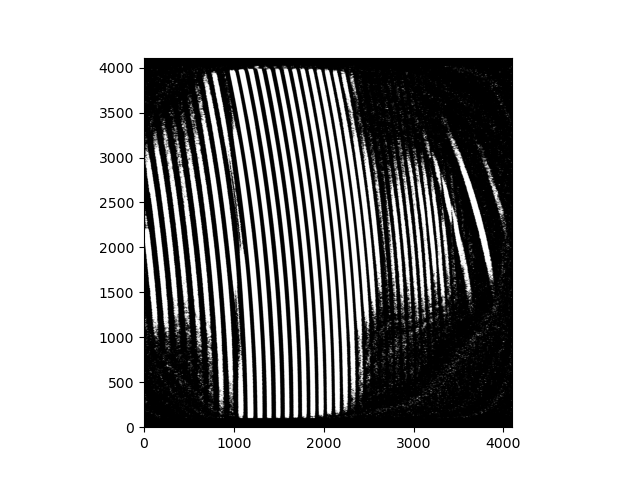

In [78]:
plt.figure()
plt.imshow(binarized, cmap='gray', origin='lower')
plt.show()

In [87]:
plt.close()

In [88]:
del blured
gc.collect()

466

In [27]:
orders = veloce_reduction_tools.get_orders_masks(binarized)

In [28]:
del binarized
gc.collect()

0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


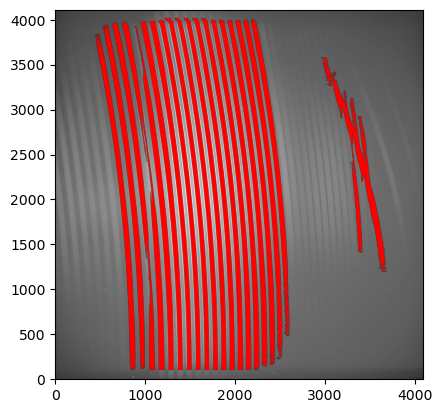

In [29]:
img_orders = merge_masks_with_alpha(orders)
plt.figure()
plt.imshow(image_subtracted_bias, cmap='gray', norm='log', origin='lower')
plt.imshow(img_orders, origin='lower')
plt.show()

In [27]:
plt.close('all')

del img_orders
gc.collect()

3285

In [ ]:
len(orders)

39

### 3. Get and smooth the trace or adjust existing one

average in x direction, and fit the polynomial

In [21]:
# traces = veloce_reduction_tools.get_traces(image_subtracted_bias, orders)

In [30]:
# del orders
# gc.collect()

Adjust existing traces by shifting in cross dispersion direction (x) to align with mid position determined by weighted average around initial trace.

In [65]:
# new_traces = veloce_reduction_tools.Traces([(y, x-21) for y, x in traces])

In [19]:
# fit_width = 35 # green
# fit_width = 25 # red
fit_width = 40 # blue
# fit_width = np.max(np.array([traces.summing_ranges_lower, traces.summing_ranges_upper]))

In [20]:
# traces = veloce_reduction_tools.refit_traces(image_subtracted_bias, x, y, fit_width=20)
# traces = veloce_reduction_tools.adjust_traces(image_subtracted_bias, x, y)
# new_traces.adjust_traces(image_subtracted_bias, fit_width=fit_width, tolerance=1e-5)
new_traces.adjust_traces(blured, fit_width=fit_width, tolerance=1e-5)

In [21]:
# load wave calibration based on ThAr
ORDER, COEFFS, MATCH_LAM, MATCH_PIX, MATCH_LRES, GUESS_LAM, Y0 = veloce_reduction_tools.load_prefitted_wave(arm=arm, wave_path=veloce_paths.wave_dir)
    

In [22]:
print(len(new_traces), len(COEFFS))

29 29


In [37]:
for order_trace, order_wave in zip(order_nums, ORDER):
    print(order_trace, order_wave)

NameError: name 'order_nums' is not defined

In [66]:
# new_traces.set_traces(new_traces.traces[1:])

In [26]:
# traces = veloce_reduction_tools.Traces(traces=new_traces, summing_ranges=summing_ranges, wavelength_slice=slice(None))

In [19]:
plt.close('all')

### 4. Work out summing range

I wanted to work out a criteria for that but in the end it was more practical to check flat, science and calibration (simultanious Th and LC) data to place borders for data extraction.

The Flat data has light in the sky fibers so the trace is ofset to the side with 3 sky fibers, this is fixed by assymetric summing range.

In [40]:
%matplotlib inline

In [24]:
%matplotlib widget

First no sim calib.

In [71]:
summing_ranges = [(35,35) for _ in range(len(new_traces.traces))]
new_traces.set_summing_range(summing_ranges)

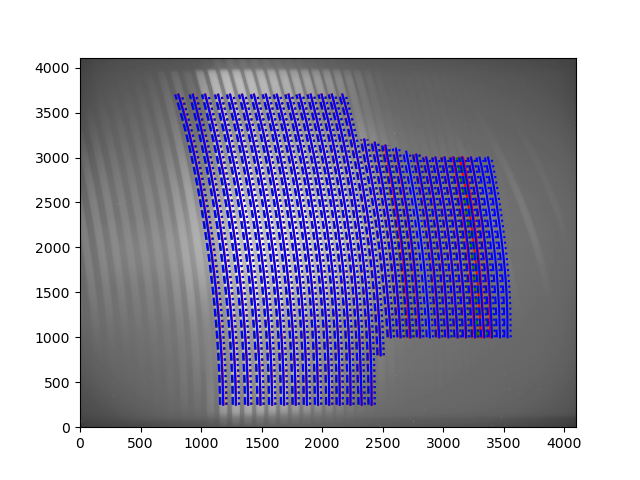

In [25]:
j = None

plt.figure()
plt.imshow(image_subtracted_bias, cmap='gray', norm="log", origin='lower', aspect='auto')
# plt.imshow(blured, cmap='gray', norm="log", origin='lower', aspect='auto')

if j is None:
    for trace_y, trace_x, lower_range, upper_range in new_traces:
        plt.plot(trace_x, trace_y, 'r')
        plt.plot(trace_x-lower_range, trace_y, 'r--')
        plt.plot(trace_x+upper_range, trace_y, 'r:')
        
        plt.plot(trace_x-25, trace_y, 'g--')
        plt.plot(trace_x+25, trace_y, 'g:')
    for trace_y, trace_x, lower_range, upper_range in traces:
        plt.plot(trace_x, trace_y, 'b')
        plt.plot(trace_x-lower_range, trace_y, 'b--')
        plt.plot(trace_x+upper_range, trace_y, 'b:')
elif j!=1:
    for trace_y, trace_x, lower_range, upper_range in zip(new_traces.y[-1*j:-1*j+1], new_traces.x[-1*j:-1*j+1], new_traces.summing_ranges_lower[-1*j:-1*j+1], new_traces.summing_ranges_upper[-1*j:-1*j+1]):
        plt.plot(trace_x, trace_y, 'r')
        plt.plot(trace_x-lower_range, trace_y, 'r--')
        plt.plot(trace_x+upper_range, trace_y, 'r:')
    for trace_y, trace_x, lower_range, upper_range in traces[-1*j:-1*j+1]:
        plt.plot(trace_x, trace_y, 'b')
        plt.plot(trace_x-lower_range, trace_y, 'b--')
        plt.plot(trace_x+upper_range, trace_y, 'b:')
else:
    for trace_y, trace_x, lower_range, upper_range in zip(new_traces.y[-1:], new_traces.x[-1:], new_traces.summing_ranges_lower[-1:], new_traces.summing_ranges_upper[-1:]):
        plt.plot(trace_x, trace_y, 'r')
        plt.plot(trace_x-lower_range, trace_y, 'r--')
        plt.plot(trace_x+upper_range, trace_y, 'r:')
    for trace_y, trace_x, lower_range, upper_range in traces[-1:]:
        plt.plot(trace_x, trace_y, 'b')
        plt.plot(trace_x-lower_range, trace_y, 'b--')
        plt.plot(trace_x+upper_range, trace_y, 'b:')

ylen, xlen = image_subtracted_bias.shape
# plt.xlim(0, xlen)
# plt.xlim(3420, 3530)
# plt.ylim(0, ylen)
# plt.ylim(2030, 2480)

plt.show()

In [ ]:
# order = 0

# plt.figure()
# plt.imshow(image_subtracted_bias, cmap='gray', norm="symlog", origin='lower', aspect='auto')

# plt.plot(new_traces.x[order], new_traces.y[order], 'r')
# plt.plot(new_traces.x[order]-new_traces.summing_ranges_lower[order], trace_y, 'r--')
# plt.plot(new_traces.x[order]+new_traces.summing_ranges_upper, new_traces.y[order], 'r:')

# ylen, xlen = image_subtracted_bias.shape
# plt.xlim(0, xlen)
# plt.ylim(0, ylen)

# plt.show()

In [54]:
plt.close('all')

In [46]:
len(new_traces)

40

In [ ]:
# new_traces.set_traces(new_traces.traces[0:-1])
# new_traces.set_summing_range(summing_ranges[0:-1])
# new_traces.wave_calib_slice = slice(None, -1)

In [56]:
filename = f'veloce_{arm}_{amp_mode}amp_sim_calib_trace_{header["DATE-OBS"]}'
# filename = f'veloce_{arm}_{amp_mode}amp_no_sim_calib_trace'
new_traces.save_traces(arm=arm, amp_mode=amp_mode, sim_calib=True, filename=filename, trace_dir=trace_path)

And now for the case with sim calib

In [38]:
### science data with LC
# data_path = '/home/usqobserver2/VeloceData'
# run = 'CSV_Run'
# night = '230826'
# ccd = 'ccd_3'
det_num = ccd.split('_')[1]
# filename = f'26aug{det_num}0148.fits'
filename = f'04apr{det_num}0082.fits'
spectrum_filename =  os.path.join(data_path, run, night, ccd, filename)

In [116]:
### SimTh 
# data_path = '/home/usqobserver2/VeloceData'
# run = 'CSV_Run'
# night = '230826'
# ccd = 'ccd_2'
# filename = f'26aug20074.fits'
# spectrum_filename =  os.path.join(data_path, run, night, ccd, filename)

In [ ]:
with fits.open(spectrum_filename) as hdul:
    image_data = hdul[0].data
    header = hdul[0].header
image_subtracted_bias = veloce_reduction_tools.remove_overscan_bias(image_data, hdr=header, arm=arm, amplifier_mode=amp_mode, overscan_range=32)

Gain for half 1: 1.01
Gain for half 2: 0.97364


In [40]:
del image_data, header
gc.collect()

1748

In [41]:
%matplotlib inline

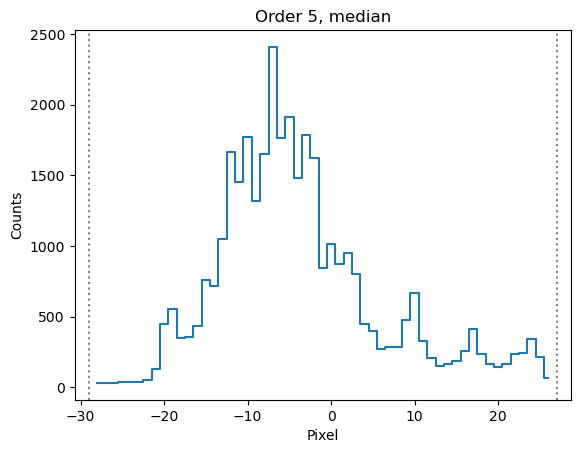

In [42]:
plt.figure()
order_img = veloce_reduction_tools.plot_order_cross_section(image_subtracted_bias, new_traces, 5, margin=[0,0])
plt.show()

In [121]:
plt.close()

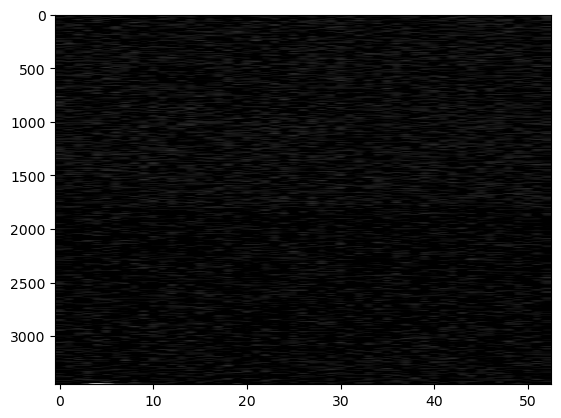

In [122]:
plt.figure()
plt.imshow(order_img, cmap='gray', norm='log', aspect='auto')
plt.show()

In [84]:
# plt.close()

In [112]:
del order_img
gc.collect()

3064

For red from CSV Run: (25,23) <br>
For green from CSV Run: (28,26) - sim calib, (36,36) - no calib <br>
For blue from CSV Run: () <br>

For green from Xmas run: () <br>
For red from Xmas Run: () <br>
For Blue from Xmas Run: () <br>

For green 2 amp mode: () <br>
For red 2 amp mode: () <br>
For blue 2 ampl mode: () <br>

In [26]:
%matplotlib widget

In [86]:
summing_ranges = [(26,26) for _ in range(len(new_traces.traces))]
new_traces.set_summing_range(summing_ranges)

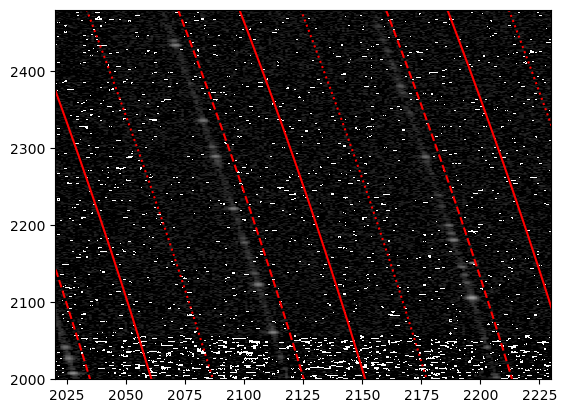

In [114]:
plt.figure()
plt.imshow(image_subtracted_bias, cmap='gray', norm="log", origin='lower', aspect='auto')

for trace_y, trace_x, lower_range, upper_range in new_traces:
    plt.plot(trace_x, trace_y, 'r')
    plt.plot(trace_x-lower_range, trace_y, 'r--')
    plt.plot(trace_x+upper_range, trace_y, 'r:')

ylen, xlen = image_subtracted_bias.shape
# plt.xlim(0, xlen)
plt.xlim(2020, 2230)
# plt.ylim(0, ylen)
plt.ylim(2000, 2480)

plt.show()

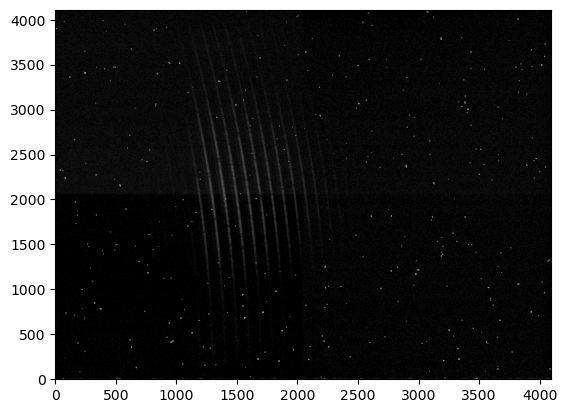

In [105]:
plt.figure()
plt.imshow(image_subtracted_bias, cmap='gray', norm="log", origin='lower', aspect='auto')
plt.show()

In [50]:
plt.close('all')

In [123]:
new_traces.save_traces(arm=arm, amp_mode=amp_mode, sim_calib=True)

### 5. Save traces

In [ ]:
### green from CSV Run - after inspection edge orders are incomplete and not usable
# traces=traces[1:-1]
# summing_ranges=summing_ranges[1:-1]

# np.savez('./Trace/veloce_green_4amp_trace', traces=traces, summing_ranges=summing_ranges)

In [59]:
### red from CSV Run - after inspection first order (104) is incomplete and wasn't identified removing it from - loading data  
# traces=traces[1:-1]
# summing_ranges=summing_ranges[1:-1]

np.savez('./Trace/veloce_green_4amp_no_sim_calib_trace', traces=traces, summing_ranges=summing_ranges)

In [126]:
# save_traces(traces=adjusted_traces, summing_ranges=summing_ranges, wave_calib_slice=slice(None), filename='veloce_green_fromTh_4amp_no_sim_calib_trace')
# new_traces.save_traces(filename='veloce_green_4amp_no_sim_calib_trace')
# new_traces.save_traces(arm=arm, amp_mode=amp_mode, sim_calib=False)

In [ ]:
# def get_file_type(filename):
#     if filename.endswith('.fits'):
#         with fits.open(filename) as hdul:
#             header = hdul[0].header
        

In [ ]:
# def scan_input_dir(veloce_paths, config):
#     """
#     Scans the input directory for files and returns a list of files.

#     Parameters:
#     - veloce_paths (VelocePaths): An instance of the VelocePaths class containing the input directory path.

#     Returns:
#     - list: A list of files in the input directory.
#     """
#     files = os.listdir(veloce_paths.input_dir)

#     obs_list = {'flat_red': [], 'flat_green': [], 'flat_blue': [], 'flat_blue_long': [],
#             'ARC-ThAr': [], 'SimThLong': [], 'SimTh': [], 'SimLC': [],
#             'dark': [], 'bias': [], 'science': []}

#     arms = {'red': 3, 'green': 2, 'blue': 1, 'all': None}
#     with open(log_path, 'r') as f:
#         lines = f.readlines()
#         for line in lines[10:]:
#             if line[0:4].isdigit():
#                 run, arm, target, exp_time = [line.split()[i] for i in [0, 1, 2, 5]]
#                 file_name = f'{day}{arm}{run}.fits'
#                 if int(arm) == arms[selected_arm] or selected_arm == 'all':
#                     if target.strip() == 'BiasFrame':
#                         obs_list['bias'].append(file_name)
#                     elif target.strip() == 'FlatField-Quartz':
#                         if float(exp_time) == 0.1:
#                             obs_list['flat_red'].append(file_name)
#                         elif float(exp_time) == 1.0:
#                             obs_list['flat_green'].append(file_name)
#                         elif float(exp_time) == 10.0:
#                             obs_list['flat_blue'].append(file_name)
#                         elif float(exp_time) == 60.0:
#                             obs_list['flat_blue_long'].append(file_name)
#                         else:
#                             pass
#                             # print(f"[Warning]: Non standard flat exp time = {exp_time} for {file_name}")
#                     elif target.strip() == 'ARC-ThAr':
#                         obs_list['ARC-ThAr'].append(file_name)
#                     elif target.strip() == 'SimThLong':
#                         obs_list['SimThLong'].append(file_name)
#                     elif target.strip() == 'SimTh':
#                         obs_list['SimTh'].append(file_name)
#                     elif target.strip() == 'SimLC':
#                         obs_list['SimLC'].append(file_name)
#                     elif target.strip() == 'DarkFrame':
#                         obs_list['dark'].append(file_name)
#                     elif target.strip() in science_targets or science_targets is None:
#                         obs_list['science'].append([target.strip(), file_name])
#                     else:
#                         pass
                    
#     return obs_list